In [6]:
# =============================================================================
#   paint_ds: Definición de funciones modulares para todo el flujo
# =============================================================================

# 1) Imports y configuración global
%load_ext autoreload
%autoreload 2

import sys, os, json, argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Añade rutas de tu proyecto
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)
sys.path.append(os.path.abspath("../scripts"))
sys.path.append(os.path.abspath("../"))

# Desactivar LaTeX por defecto (evita errores si no está instalado)
plt.rcParams['text.usetex'] = False

# Tus componentes
from scripts.model import MILModel, AttentionMechanism
from data.datasets.SCStandardMILDataset import SCStandardMILDataset
from data.datasets.MCStandardMILDataset import MCStandardMILDataset
from data.datasets.MCStandard_MIO import MCStandard_MIO
from data.datasets.FalseFrequencyMILDataset import FalseFrequencyMILDataset

# 2) Dataset & DataLoader
def make_dataloaders(dataset_cls, D, num_bags, B, batch_size=1):
    """Crea train/test loaders para un SC-like Dataset."""
    train_ds = dataset_cls(D=D, num_bags=num_bags, B=B, train=True)
    test_ds  = dataset_cls(D=D, num_bags=num_bags, B=B, train=False)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              collate_fn=train_ds.collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              collate_fn=test_ds.collate_fn)
    return train_loader, test_loader

# 3) Entrenamiento
def train_mil_model(train_loader, feature_dim, pooling, lr, epochs, save_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MILModel(input_feature_dim=feature_dim, pooling_type=pooling).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        model.train()
        tot = 0
        for X, Y, _, adj, mask in train_loader:
            X, Y, mask = X.to(device), Y.float().unsqueeze(1).to(device), mask.to(device)
            logits, _ = model(X, mask=mask)
            loss = criterion(torch.sigmoid(logits), Y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            tot += loss.item()
        print(f"Epoch {ep}/{epochs} — Loss: {tot/len(train_loader):.4f}")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print("Modelo guardado en", save_path)
    return model

# 4) Evaluación
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix

def evaluate_mil_model(model, test_loader):
    device = next(model.parameters()).device
    model.eval()
    ys, ps, preds = [], [], []
    with torch.no_grad():
        for X, Y, _, adj, mask in test_loader:
            X, Y, mask = X.to(device), Y.to(device), mask.to(device)
            logits, _ = model(X, mask=mask)
            prob = torch.sigmoid(logits).item()
            pred = int(prob>0.5)
            ys.append(int(Y.item())); ps.append(prob); preds.append(pred)
    acc = accuracy_score(ys, preds)
    auc = roc_auc_score(ys, ps)
    f1  = f1_score(ys, preds)
    cm  = confusion_matrix(ys, preds)
    print(f"Acc: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")
    print("CM:\n", cm)

# 5) OOD scorers
def msp_score(model, x, mask):
    model.eval()
    with torch.no_grad():
        logits, _ = model(x, mask=mask)
        p = torch.sigmoid(logits)
        p_max = torch.max(torch.cat([p, 1-p], dim=1), dim=1).values
    return (1-p_max).cpu().numpy()

def energy_score(model, x, mask, T=1.0):
    model.eval()
    with torch.no_grad():
        logits, _ = model(x, mask=mask)
        e = -T * torch.logsumexp(logits/T, dim=1)
    return e.cpu().numpy()

def get_model_ood_scorers():
    return {"MSP": msp_score, "Energy": energy_score}

def compute_ood_scores(model, test_loader):
    device = next(model.parameters()).device
    scorers = get_model_ood_scorers()
    scores = {k: [] for k in scorers}
    with torch.no_grad():
        for X, Y, _, adj, mask in test_loader:
            X, mask = X.to(device), mask.to(device)
            for name, fn in scorers.items():
                sc = fn(model, X, mask)
                scores[name].extend(sc.tolist())
    for name, vals in scores.items():
        print(f"{name}: mean={np.mean(vals):.4f}, std={np.std(vals):.4f}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

# 6) Visualización atención y bolsas
def get_first_positive(loader, device):
    for X,Y,y_inst,adj,mask in loader:
        if Y.item()==1:
            return X.to(device), y_inst.to(device), mask.to(device)
    raise RuntimeError("Sin bolsa positiva")

def plot_positive_bag_attention(loader, model, device, dims=(0,1)):
    """
    Visualiza la primera bolsa positiva del `loader`, coloreando las instancias por su atención,
    y dibuja la representación de la bolsa como un punto dorado.
    """

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams['text.usetex'] = False  # Por si no tienes LaTeX
    import torch

    # Buscar la primera bolsa positiva
    for X_batch, Y_batch, _, _, mask_batch in loader:
        if Y_batch.item() == 1:
            X_pos, mask_pos = X_batch.to(device), mask_batch.to(device)
            break

    # Forward
    model.eval()
    with torch.no_grad():
        logits, attn_weights = model(X_pos, mask=mask_pos)
        features = X_pos  # características ya preextraídas
        bag_repr = torch.bmm(attn_weights.unsqueeze(1), features).squeeze(1)

    # Convertir a numpy
    X_np    = X_pos.squeeze(0).cpu().numpy()
    Z_np    = bag_repr.squeeze(0).cpu().numpy()
    att_np  = attn_weights.squeeze(0).cpu().numpy()

    # Gráfico
    plt.figure(figsize=(7,6))
    scatter = plt.scatter(
        X_np[:,dims[0]], X_np[:,dims[1]],
        c=att_np, cmap='Reds', s=60, edgecolors='k',
        label='Instancias (coloreadas por atención)'
    )
    plt.colorbar(scatter, label='Peso de atención')
    plt.scatter(
        Z_np[dims[0]], Z_np[dims[1]],
        c='gold', edgecolors='k', s=200,
        label='Representación de la bolsa'
    )

    plt.title("Visualización de una bolsa positiva con pesos de atención")
    plt.xlabel(f"Dimensión {dims[0]}")
    plt.ylabel(f"Dimensión {dims[1]}")
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

def plot_attention_trajectories(loader, model, device, lambdas=None, dims=(0,1)):
    """
    Para la primera bolsa positiva, varía cada λ en `lambdas`,
    y dibuja las representaciones Z (dims) resultantes, con leyenda.
    """
    if lambdas is None:
        lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5, 10]
    
    X, _, mask = get_first_positive(loader, device)
    X_np = X.squeeze(0).cpu().numpy()
    
    plt.figure(figsize=(6,6))
    # Plot de instancias
    plt.scatter(
        X_np[:,dims[0]], X_np[:,dims[1]],
        c='lightgray', edgecolors='k', alpha=0.7,
        label='Instancias'
    )

    # Guardamos el forward original
    orig_forward = model.attention.forward

    # Para cada λ, parcheamos, calculamos Z y ploteamos
    for lamb in lambdas:
        def scaled_forward(self, features, mask=None, _l=lamb):
            scores = self.attention_layer(features).squeeze(-1)
            if mask is not None:
                scores = scores.masked_fill(~mask.bool(), float('-inf'))
            scores = scores * _l
            weights = F.softmax(scores, dim=1)
            bag = torch.bmm(weights.unsqueeze(1), features).squeeze(1)
            return bag, weights

        # Monkey-patch
        model.attention.forward = scaled_forward.__get__(model.attention, type(model.attention))

        # Forward para Z
        model.eval()
        with torch.no_grad():
            Z, _ = model.attention(X.to(device), mask=mask)
            z = Z.squeeze(0).cpu().numpy()

        # Plot Z
        plt.scatter(
            z[dims[0]], z[dims[1]],
            edgecolors='k', s=50,
            label=f"λ = {lamb:g}"
        )

    # Restaurar forward original
    model.attention.forward = orig_forward

    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
    plt.title("Evolución de la representación de bolsa al variar λ")
    plt.xlabel(f"Dimensión {dims[0]}")
    plt.ylabel(f"Dimensión {dims[1]}")
    plt.tight_layout()
    plt.show()

def plot_attention_heatmap_2d(grid_size, x_range, y_range, hidden_dim=64, lambda_val=1.0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    att2d = AttentionMechanism(input_dim=2, hidden_dim=hidden_dim).to(device)
    xv = torch.linspace(x_range[0], x_range[1], grid_size)
    yv = torch.linspace(y_range[0], y_range[1], grid_size)
    gx,gy = torch.meshgrid(xv,yv,indexing='xy')
    pts = torch.stack([gx.flatten(), gy.flatten()],-1).unsqueeze(0).to(device)
    mask = torch.ones(1, pts.size(1), dtype=torch.bool, device=device)
    with torch.no_grad():
        s = att2d.attention_layer(pts).squeeze(-1)
        s = s.masked_fill(~mask, -1e9)*lambda_val
        w = F.softmax(s,dim=1)
    amap = w.cpu().numpy().reshape(grid_size,grid_size)
    plt.figure(figsize=(6,5))
    plt.imshow(amap, extent=[*x_range,*y_range], origin='lower', cmap='viridis')
    plt.colorbar(label='Peso atención')
    plt.title(f"Heatmap 2D (λ={lambda_val})")
    plt.xlabel("X"); plt.ylabel("Y"); plt.show()

Epoch 1/5 — Loss: 0.1924
Epoch 2/5 — Loss: 0.0419
Epoch 3/5 — Loss: 0.0342
Epoch 4/5 — Loss: 0.0193
Epoch 5/5 — Loss: 0.0112
Modelo guardado en models/scstandard/model_attn.pth
Acc: 0.0050, AUC: 0.0023, F1: 0.0040
CM:
 [[  3 497]
 [498   2]]
MSP: mean=0.0552, std=0.0893
Energy: mean=15.1943, std=20.1284


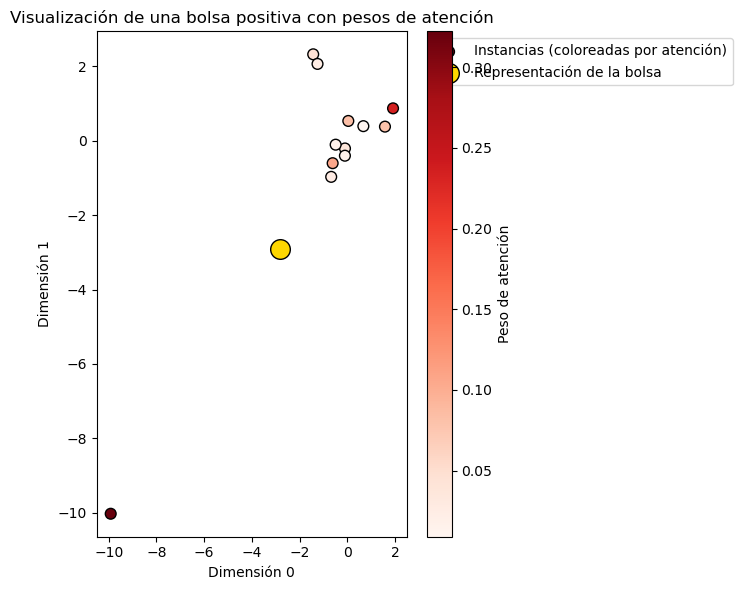

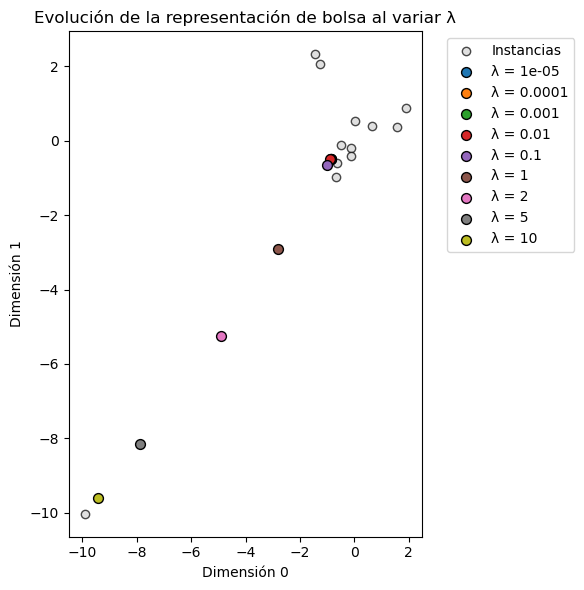

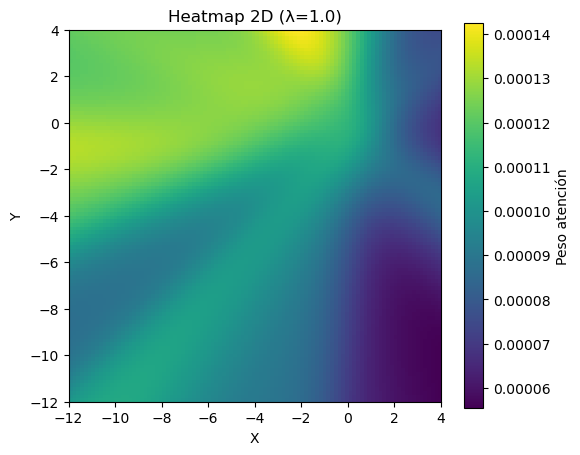

In [ ]:
# -----------------------------------------------------------------------------
#   paint_ds: Usa las funciones definidas arriba
# -----------------------------------------------------------------------------

# 1) Crear loaders
train_loader, test_loader = make_dataloaders(SCStandardMILDataset,
                                            D=128, num_bags=1000, B=10)

# 2) Entrenar y guardar (opcional si ya tienes modelo)
model = train_mil_model(train_loader,
                        feature_dim=128,
                        pooling='attention',
                        lr=1e-3,
                        epochs=3,
                        save_path='models/scstandard/model_attn.pth')

# 3) Evaluar
evaluate_mil_model(model, test_loader)

# 4) OOD scores
compute_ood_scores(model, test_loader)

# 5) Visualizaciones
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LAMBDAS = [0.1, 1, 10] # Valores de λ para la visualización
DIMS   = (0,1)
XRANGE = (-12,4)
YRANGE = (-12,4)

plot_positive_bag_attention(test_loader, model, DEVICE, dims=DIMS)
plot_attention_trajectories(test_loader, model, DEVICE, dims=(0,1))
plot_attention_heatmap_2d(grid_size=100,
                         x_range=XRANGE,
                         y_range=YRANGE,
                         hidden_dim=32,
                         lambda_val=1.0)


REPRESENTACION CON GRAFICAS DE CLAUDE

In [19]:
# 6) Visualización atención y bolsas
def get_first_positive(loader, device):
    """
    Obtiene la primera bolsa positiva del dataloader.
    
    Args:
        loader: DataLoader de PyTorch
        device: Dispositivo donde procesar los tensores
        
    Returns:
        X: Tensor de características
        y_inst: Etiqueta de instancias
        mask: Máscara de instancias válidas
    """
    for X, Y, y_inst, adj, mask in loader:
        if Y.item() == 1:
            return X.to(device), y_inst.to(device), mask.to(device)
    raise RuntimeError("No se encontró ninguna bolsa positiva en el dataset")

def get_first_negative(loader, device):
    """
    Obtiene la primera bolsa negativa del dataloader.
    
    Args:
        loader: DataLoader de PyTorch
        device: Dispositivo donde procesar los tensores
        
    Returns:
        X: Tensor de características
        y_inst: Etiqueta de instancias
        mask: Máscara de instancias válidas
    """
    for X, Y, y_inst, adj, mask in loader:
        if Y.item() == 0:
            return X.to(device), y_inst.to(device), mask.to(device)
    raise RuntimeError("No se encontró ninguna bolsa negativa en el dataset")

def plot_positive_bag_attention(loader, model, device, dims=(0,1), save_path=None):
    """
    Visualiza la primera bolsa positiva del `loader`, coloreando las instancias por su atención,
    y dibuja la representación de la bolsa como un punto dorado.
    
    Args:
        loader: DataLoader del dataset
        model: Modelo MIL entrenado
        device: Dispositivo donde procesar los tensores
        dims: Tupla con las dimensiones a visualizar (por defecto: (0,1))
        save_path: Ruta donde guardar la figura (opcional)
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.patches import Patch
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    mpl.rcParams['text.usetex'] = False

    # Buscar la primera bolsa positiva
    for X_batch, Y_batch, y_inst_batch, _, mask_batch in loader:
        if Y_batch.item() == 1:
            X_pos = X_batch.to(device)
            y_inst_pos = y_inst_batch.to(device)
            mask_pos = mask_batch.to(device)
            break

    # Forward
    model.eval()
    with torch.no_grad():
        logits, attn_weights = model(X_pos, mask=mask_pos)
        features = X_pos  # características ya preextraídas
        bag_repr = torch.bmm(attn_weights.unsqueeze(1), features).squeeze(1)
        prob = torch.sigmoid(logits).item()

    # Convertir a numpy
    X_np = X_pos.squeeze(0).cpu().numpy()
    Z_np = bag_repr.squeeze(0).cpu().numpy()
    att_np = attn_weights.squeeze(0).cpu().numpy()
    y_inst_np = y_inst_pos.squeeze(0).cpu().numpy() if y_inst_pos is not None else None

    # Crear figura y ejes
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calcular tamaños según atención
    sizes = 100 + 300 * att_np
    
    # Dibujar instancias positivas y negativas con diferentes marcadores si hay etiquetas disponibles
    if y_inst_np is not None and y_inst_np.size > 0:
        pos_indices = y_inst_np == 1
        neg_indices = y_inst_np == 0
        
        # Instancias positivas (triángulos)
        if pos_indices.any():
            scatter_pos = ax.scatter(
                X_np[pos_indices, dims[0]], X_np[pos_indices, dims[1]],
                c=att_np[pos_indices], cmap='Reds', s=sizes[pos_indices], 
                marker='^', edgecolors='k', linewidth=1,
                label='Instancias positivas'
            )
        
        # Instancias negativas (círculos)
        if neg_indices.any():
            scatter_neg = ax.scatter(
                X_np[neg_indices, dims[0]], X_np[neg_indices, dims[1]],
                c=att_np[neg_indices], cmap='Blues', s=sizes[neg_indices], 
                marker='o', edgecolors='k', linewidth=1,
                label='Instancias negativas'
            )
    else:
        # Si no tenemos etiquetas de instancia, usar un solo color
        scatter = ax.scatter(
            X_np[:, dims[0]], X_np[:, dims[1]],
            c=att_np, cmap='viridis', s=sizes, 
            edgecolors='k', linewidth=1,
            label='Instancias (tamaño y color por atención)'
        )
    
    # Representación de la bolsa
    bag = ax.scatter(
        Z_np[dims[0]], Z_np[dims[1]],
        c='gold', edgecolors='k', s=300, marker='*',
        label='Representación de la bolsa'
    )
    
    # Añadir líneas desde cada instancia a la representación de bolsa
    for i in range(len(X_np)):
        # La opacidad de la línea depende del peso de atención
        alpha = min(1.0, att_np[i] * 5)  # Escalar para mejor visualización
        if alpha > 0.05:  # Solo dibujar líneas significativas
            ax.plot([X_np[i, dims[0]], Z_np[dims[0]]], 
                   [X_np[i, dims[1]], Z_np[dims[1]]],
                   'k--', alpha=alpha, linewidth=0.8)
    
    # Etiquetas de las instancias con mayor atención
    top_n = 3
    top_indices = att_np.argsort()[-top_n:]
    for i in top_indices:
        ax.annotate(f"w={att_np[i]:.3f}", 
                   (X_np[i, dims[0]], X_np[i, dims[1]]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))
    
    # Añadir colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scatter if 'scatter' in locals() else scatter_pos, cax=cax)
    cbar.set_label('Peso de atención')
    
    # Añadir título con información de predicción
    ax.set_title(f"Bolsa positiva (pred={prob:.3f})\nPesos de atención en instancias", fontsize=14)
    ax.set_xlabel(f"Dimensión {dims[0]}", fontsize=12)
    ax.set_ylabel(f"Dimensión {dims[1]}", fontsize=12)
    
    # Crear una leyenda personalizada
    legend_elements = []
    if 'scatter_pos' in locals():
        legend_elements.append(Patch(facecolor='red', edgecolor='k', label='Instancias positivas'))
    if 'scatter_neg' in locals():
        legend_elements.append(Patch(facecolor='blue', edgecolor='k', label='Instancias negativas'))
    if 'scatter' in locals():
        legend_elements.append(Patch(facecolor='green', edgecolor='k', label='Instancias'))
    legend_elements.append(Patch(facecolor='gold', edgecolor='k', label='Representación de bolsa'))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
    
    # Añadir cuadrícula
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Establecer límites más adecuados
    ax.set_xlim(X_np[:, dims[0]].min() - 1, X_np[:, dims[0]].max() + 1)
    ax.set_ylim(X_np[:, dims[1]].min() - 1, X_np[:, dims[1]].max() + 1)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, ax

def plot_comparative_bags(loader, model, device, dims=(0,1), save_path=None):
    """
    Visualiza una bolsa positiva y una negativa para comparación.
    
    Args:
        loader: DataLoader del dataset
        model: Modelo MIL entrenado
        device: Dispositivo donde procesar los tensores
        dims: Tupla con las dimensiones a visualizar (por defecto: (0,1))
        save_path: Ruta donde guardar la figura (opcional)
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.patches import Patch
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    mpl.rcParams['text.usetex'] = False
    
    # Obtener una bolsa positiva y una negativa
    try:
        X_pos, y_inst_pos, mask_pos = get_first_positive(loader, device)
        X_neg, y_inst_neg, mask_neg = get_first_negative(loader, device)
    except RuntimeError as e:
        print(f"Error: {e}")
        return None, None
    
    # Crear figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Procesar cada bolsa
    for idx, (X, y_inst, mask, ax, title_prefix) in enumerate([
        (X_pos, y_inst_pos, mask_pos, axes[0], "Bolsa Positiva"),
        (X_neg, y_inst_neg, mask_neg, axes[1], "Bolsa Negativa")
    ]):
        # Forward
        model.eval()
        with torch.no_grad():
            logits, attn_weights = model(X, mask=mask)
            features = X  # características ya preextraídas
            bag_repr = torch.bmm(attn_weights.unsqueeze(1), features).squeeze(1)
            prob = torch.sigmoid(logits).item()
        
        # Convertir a numpy
        X_np = X.squeeze(0).cpu().numpy()
        Z_np = bag_repr.squeeze(0).cpu().numpy()
        att_np = attn_weights.squeeze(0).cpu().numpy()
        y_inst_np = y_inst.squeeze(0).cpu().numpy() if y_inst is not None else None
        
        # Calcular tamaños según atención
        sizes = 50 + 200 * att_np
        
        # Dibujar instancias con etiquetas disponibles
        if y_inst_np is not None and y_inst_np.size > 0:
            pos_indices = y_inst_np == 1
            neg_indices = y_inst_np == 0
            
            # Instancias positivas (triángulos)
            if pos_indices.any():
                scatter_pos = ax.scatter(
                    X_np[pos_indices, dims[0]], X_np[pos_indices, dims[1]],
                    c=att_np[pos_indices], cmap='Reds', s=sizes[pos_indices], 
                    marker='^', edgecolors='k', linewidth=1,
                    label='Instancias positivas'
                )
            
            # Instancias negativas (círculos)
            if neg_indices.any():
                scatter_neg = ax.scatter(
                    X_np[neg_indices, dims[0]], X_np[neg_indices, dims[1]],
                    c=att_np[neg_indices], cmap='Blues', s=sizes[neg_indices], 
                    marker='o', edgecolors='k', linewidth=1,
                    label='Instancias negativas'
                )
        else:
            # Si no tenemos etiquetas de instancia, usar un solo color
            scatter = ax.scatter(
                X_np[:, dims[0]], X_np[:, dims[1]],
                c=att_np, cmap='viridis', s=sizes, 
                edgecolors='k', linewidth=1,
                label='Instancias'
            )
        
        # Representación de la bolsa
        bag_color = 'gold' if idx == 0 else 'purple'
        bag = ax.scatter(
            Z_np[dims[0]], Z_np[dims[1]],
            c=bag_color, edgecolors='k', s=300, marker='*',
            label='Representación de la bolsa'
        )
        
        # Añadir líneas desde las instancias significativas a la representación de bolsa
        for i in range(len(X_np)):
            alpha = min(1.0, att_np[i] * 5)
            if alpha > 0.05:
                ax.plot([X_np[i, dims[0]], Z_np[dims[0]]], 
                       [X_np[i, dims[1]], Z_np[dims[1]]],
                       'k--', alpha=alpha, linewidth=0.8)
        
        # Etiquetas para instancias con mayor atención
        top_n = 2
        top_indices = att_np.argsort()[-top_n:]
        for i in top_indices:
            ax.annotate(f"w={att_np[i]:.3f}", 
                       (X_np[i, dims[0]], X_np[i, dims[1]]),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))
        
        # Añadir colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        if 'scatter' in locals():
            cbar = plt.colorbar(scatter, cax=cax)
        elif 'scatter_pos' in locals():
            cbar = plt.colorbar(scatter_pos, cax=cax)
        else:
            cbar = plt.colorbar(scatter_neg, cax=cax)
        cbar.set_label('Peso de atención')
        
        # Configurar títulos y etiquetas
        ax.set_title(f"{title_prefix} (pred={prob:.3f})\nPesos de atención", fontsize=14)
        ax.set_xlabel(f"Dimensión {dims[0]}", fontsize=12)
        ax.set_ylabel(f"Dimensión {dims[1]}", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Establecer límites
        margin = 1
        ax.set_xlim(X_np[:, dims[0]].min() - margin, X_np[:, dims[0]].max() + margin)
        ax.set_ylim(X_np[:, dims[1]].min() - margin, X_np[:, dims[1]].max() + margin)
    
    # Añadir título general
    fig.suptitle("Comparativa de Bolsas Positivas vs Negativas en MIL", fontsize=16, y=0.98)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, axes

def plot_attention_trajectories(loader, model, device, lambdas=None, dims=(0,1), save_path=None):
    """
    Para la primera bolsa positiva, varía cada λ en `lambdas`,
    y dibuja las representaciones Z (dims) resultantes, con leyenda.
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import numpy as np  # Añadido el import de numpy que faltaba
    import torch
    import torch.nn.functional as F
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    mpl.rcParams['text.usetex'] = False
    
    if lambdas is None:
        lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5, 10]
    
    X, y_inst, mask = get_first_positive(loader, device)
    X_np = X.squeeze(0).cpu().numpy()
    
    # Guardamos el forward original
    orig_forward = model.attention.forward
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Añadir texto explicativo
    explanation_text = """
    Este gráfico muestra cómo cambia la representación de la bolsa (Z)
    al variar el parámetro λ que controla la "temperatura" de la atención.
    """
    ax.text(0.02, 0.98, explanation_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Dibujar instancias con colores según etiquetas si están disponibles
    y_inst_np = y_inst.squeeze(0).cpu().numpy() if y_inst is not None else None
    
    if y_inst_np is not None and y_inst_np.size > 0:
        pos_indices = y_inst_np == 1
        neg_indices = y_inst_np == 0
        
        if pos_indices.any():
            ax.scatter(
                X_np[pos_indices, dims[0]], X_np[pos_indices, dims[1]],
                c='lightcoral', edgecolors='k', alpha=0.7, s=80, marker='^',
                label='Instancias positivas'
            )
        
        if neg_indices.any():
            ax.scatter(
                X_np[neg_indices, dims[0]], X_np[neg_indices, dims[1]],
                c='lightblue', edgecolors='k', alpha=0.7, s=80, marker='o',
                label='Instancias negativas'
            )
    else:
        ax.scatter(
            X_np[:, dims[0]], X_np[:, dims[1]],
            c='lightgray', edgecolors='k', alpha=0.7, s=80,
            label='Instancias'
        )
    
    # Colores para los diferentes lambdas
    import matplotlib.cm as cm
    cmap = cm.get_cmap('viridis', len(lambdas))
    
    # Para cada λ, parcheamos, calculamos Z y ploteamos
    z_values = []
    weights_values = []
    
    for i, lamb in enumerate(lambdas):
        def scaled_forward(self, features, mask=None, _l=lamb):
            scores = self.attention_layer(features).squeeze(-1)
            if mask is not None:
                scores = scores.masked_fill(~mask.bool(), float('-inf'))
            scores = scores * _l  # Multiplicar por lambda
            weights = F.softmax(scores, dim=1)
            bag = torch.bmm(weights.unsqueeze(1), features).squeeze(1)
            return bag, weights

        # Monkey-patch
        model.attention.forward = scaled_forward.__get__(model.attention, type(model.attention))

        # Forward para Z
        model.eval()
        with torch.no_grad():
            Z, weights = model.attention(X.to(device), mask=mask)
            z = Z.squeeze(0).cpu().numpy()
            w = weights.squeeze(0).cpu().numpy()
            
        z_values.append(z)
        weights_values.append(w)
        
        # Plot Z con color según lambda y tamaño creciente
        ax.scatter(
            z[dims[0]], z[dims[1]],
            color=cmap(i), edgecolors='k', s=100 + i*20, marker='*',
            label=f"λ = {lamb:g}"
        )
    
    # Restaurar forward original
    model.attention.forward = orig_forward
    
    # Conectar puntos Z en secuencia para mostrar la trayectoria
    z_points = np.array([(z[dims[0]], z[dims[1]]) for z in z_values])
    ax.plot(z_points[:, 0], z_points[:, 1], 'k-', alpha=0.5, linewidth=1.5)
    
    # Añadir flechas para indicar la dirección de la trayectoria
    for i in range(len(z_points) - 1):
        ax.annotate('', xy=z_points[i+1], xytext=z_points[i],
                   arrowprops=dict(arrowstyle='->',
                                  color='darkgray',
                                  lw=1.5,
                                  alpha=0.7))
    
    # Calcular entropía de los pesos para cada lambda
    from scipy.stats import entropy
    entropies = [entropy(w) for w in weights_values]
    normalized_entropies = [e/np.log(len(w)) for e, w in zip(entropies, weights_values)]
    
    # Crear un subplot para entropía
    ax_entropy = fig.add_axes([0.15, 0.15, 0.2, 0.15])
    ax_entropy.plot(range(len(lambdas)), normalized_entropies, 'o-', color='darkred')
    ax_entropy.set_xticks(range(len(lambdas)))
    ax_entropy.set_xticklabels([f"{l:g}" for l in lambdas], rotation=45, fontsize=8)
    ax_entropy.set_title('Entropía Normalizada', fontsize=9)
    ax_entropy.set_xlabel('λ', fontsize=8)
    ax_entropy.grid(True, linestyle='--', alpha=0.7)
    
    # Configuración general del gráfico principal
    ax.set_title("Evolución de la representación de bolsa al variar λ", fontsize=14)
    ax.set_xlabel(f"Dimensión {dims[0]}", fontsize=12)
    ax.set_ylabel(f"Dimensión {dims[1]}", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Mejorar la leyenda
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
    
    # Establecer límites más adecuados
    margin = 1
    min_x = min(min(X_np[:, dims[0]]), min(z[dims[0]] for z in z_values)) - margin
    max_x = max(max(X_np[:, dims[0]]), max(z[dims[0]] for z in z_values)) + margin
    min_y = min(min(X_np[:, dims[1]]), min(z[dims[1]] for z in z_values)) - margin
    max_y = max(max(X_np[:, dims[1]]), max(z[dims[1]] for z in z_values)) + margin
    
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, ax

def plot_attention_heatmap_2d(grid_size, x_range, y_range, hidden_dim=64, lambda_val=1.0, save_path=None):
    """
    Visualiza un mapa de calor 2D de la función de atención.
    
    Args:
        grid_size: Tamaño de la cuadrícula para la visualización
        x_range: Rango en el eje X (tupla: min, max)
        y_range: Rango en el eje Y (tupla: min, max)
        hidden_dim: Dimensión oculta para el mecanismo de atención
        lambda_val: Valor de lambda (temperatura) para la atención
        save_path: Ruta donde guardar la figura (opcional)
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.colors import LinearSegmentedColormap
    import numpy as np
    mpl.rcParams['text.usetex'] = False
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    att2d = AttentionMechanism(input_dim=2, hidden_dim=hidden_dim).to(device)
    
    # Crear una cuadrícula más fina
    xv = torch.linspace(x_range[0], x_range[1], grid_size)
    yv = torch.linspace(y_range[0], y_range[1], grid_size)
    gx, gy = torch.meshgrid(xv, yv, indexing='xy')
    pts = torch.stack([gx.flatten(), gy.flatten()], -1).unsqueeze(0).to(device)
    mask = torch.ones(1, pts.size(1), dtype=torch.bool, device=device)
    
    # Obtener pesos de atención
    with torch.no_grad():
        s = att2d.attention_layer(pts).squeeze(-1)
        s = s.masked_fill(~mask, -1e9) * lambda_val
        w = F.softmax(s, dim=1)
    
    amap = w.cpu().numpy().reshape(grid_size, grid_size)
    
    # Crear figura con múltiples paneles
    fig = plt.figure(figsize=(15, 10))
    
    # Panel principal: heatmap de atención
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2)
    
    # Crear un colormap personalizado más atractivo
    colors = ['darkblue', 'blue', 'lightblue', 'lightgreen', 'yellow', 'orange', 'red', 'darkred']
    custom_cmap = LinearSegmentedColormap.from_list('custom_attention', colors, N=256)
    
    im = ax1.imshow(amap, extent=[*x_range, *y_range], origin='lower', 
                    cmap=custom_cmap, aspect='auto')
    
    # Añadir contornos para mejor visualización
    levels = np.linspace(amap.min(), amap.max(), 10)
    contour = ax1.contour(amap, levels=levels, colors='black', alpha=0.5, 
                          extent=[*x_range, *y_range], origin='lower')
    plt.clabel(contour, inline=True, fontsize=8, fmt='%.3f')
    
    # Añadir colorbar
    cbar = fig.colorbar(im, ax=ax1)
    cbar.set_label('Peso de atención', fontsize=12)
    
    # Títulos y etiquetas
    ax1.set_title(f"Heatmap de Atención 2D (λ={lambda_val})", fontsize=14)
    ax1.set_xlabel("X", fontsize=12)
    ax1.set_ylabel("Y", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # Panel 2: distribución de pesos (histograma)
    ax2 = plt.subplot2grid((2, 3), (0, 2))
    ax2.hist(amap.flatten(), bins=50, color='skyblue', edgecolor='black')
    ax2.set_title('Distribución de Pesos', fontsize=12)
    ax2.set_xlabel('Valor del peso', fontsize=10)
    ax2.set_ylabel('Frecuencia', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # Panel 3: Visualización 3D del mapa de atención
    ax3 = plt.subplot2grid((2, 3), (1, 2), projection='3d')
    X, Y = np.meshgrid(xv.cpu().numpy(), yv.cpu().numpy())
    surf = ax3.plot_surface(X, Y, amap, cmap=custom_cmap, 
                           linewidth=0, antialiased=True, alpha=0.8)
    ax3.set_title('Vista 3D de Atención', fontsize=12)
    ax3.set_xlabel('X', fontsize=10)
    ax3.set_ylabel('Y', fontsize=10)
    ax3.set_zlabel('Peso', fontsize=10)
    
    # Añadir texto explicativo
    ax1.text(x_range[0] + 0.05 * (x_range[1] - x_range[0]), 
         y_range[0] + 0.05 * (y_range[1] - y_range[0]),
         f"""Interpretación del mapa de atención:
         
         - Regiones rojas: Alta atención
         - Regiones azules: Baja atención
         - λ={lambda_val} controla la "temperatura" de la atención
         - Mayor λ → Mayor contraste entre regiones""",
         fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Ajustar diseño y espaciado
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig

def visualize_attention_parameters(model, loader, device, dims=(0,1), save_path=None):
    """
    Visualiza cómo los parámetros internos de la capa de atención afectan a los pesos.
    
    Args:
        model: Modelo MIL entrenado
        loader: DataLoader del dataset
        device: Dispositivo donde procesar los tensores
        dims: Dimensiones para visualizar (por defecto: (0,1))
        save_path: Ruta donde guardar la figura (opcional)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Obtener bolsa positiva
    X, y_inst, mask = get_first_positive(loader, device)
    X_np = X.squeeze(0).cpu().numpy()
    
    # Obtener parámetros de la capa de atención
    attention_layer = model.attention.attention_layer
    # Comprobar si es un modelo secuencial o una capa directa
    if isinstance(attention_layer, nn.Sequential):
        # Obtenemos pesos de la última capa lineal
        weights = None
        for layer in attention_layer:
            if isinstance(layer, nn.Linear):
                weights = layer.weight.detach().cpu().numpy()
        if weights is None:
            weights = attention_layer[-1].weight.detach().cpu().numpy()
    else:
        # Para una capa lineal directa
        weights = attention_layer.weight.detach().cpu().numpy()
    
    # Forward para obtener scores y pesos de atención actuales
    model.eval()
    with torch.no_grad():
        logits, attn_weights = model(X, mask=mask)
        # Obtener scores antes de softmax
        scores = model.attention.attention_layer(X).squeeze(-1)
        if mask is not None:
            scores = scores.masked_fill(~mask.bool(), float('-inf'))
        
        # Convertir a numpy
        scores_np = scores.squeeze(0).cpu().numpy()
        att_weights_np = attn_weights.squeeze(0).cpu().numpy()
    
    # Crear figura con múltiples paneles
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Panel 1: Visualización de instancias con pesos actuales
    ax1 = axes[0, 0]
    scatter = ax1.scatter(
        X_np[:, dims[0]], X_np[:, dims[1]],
        c=att_weights_np, cmap='viridis', s=100, edgecolors='k',
        label='Instancias (pesos de atención)'
    )
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label('Peso de atención')
    ax1.set_title('Pesos de Atención Actuales', fontsize=12)
    ax1.set_xlabel(f'Dimensión {dims[0]}', fontsize=10)
    ax1.set_ylabel(f'Dimensión {dims[1]}', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Panel 2: Visualización de scores antes de softmax
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(
        X_np[:, dims[0]], X_np[:, dims[1]],
        c=scores_np, cmap='coolwarm', s=100, edgecolors='k',
        label='Instancias (scores pre-softmax)'
    )
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    cbar2 = plt.colorbar(scatter2, cax=cax2)
    cbar2.set_label('Score pre-softmax')
    ax2.set_title('Scores Antes de Softmax', fontsize=12)
    ax2.set_xlabel(f'Dimensión {dims[0]}', fontsize=10)
    ax2.set_ylabel(f'Dimensión {dims[1]}', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Panel 3: Visualización de pesos de la capa de atención (solo primeros componentes)
    ax3 = axes[1, 0]
    if weights.shape[1] > 10:
        # Mostrar solo las primeras 10 dimensiones si hay muchas
        weights_display = weights[:, :10]
        title_suffix = f" (primeras 10/{weights.shape[1]} dimensiones)"
    else:
        weights_display = weights
        title_suffix = ""
        
    im = ax3.imshow(weights_display, cmap='RdBu_r', aspect='auto')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    cbar3 = plt.colorbar(im, cax=cax3)
    cbar3.set_label('Valor del peso')
    ax3.set_title(f'Pesos de la Capa de Atención{title_suffix}', fontsize=12)
    ax3.set_xlabel('Dimensión de Entrada', fontsize=10)
    ax3.set_ylabel('Dimensión de Salida', fontsize=10)
    
    # Panel 4: Correlación entre scores y cada dimensión de entrada
    ax4 = axes[1, 1]
    correlations = []
    for i in range(min(10, X_np.shape[1])):  # Mostrar hasta 10 dimensiones
        corr = np.corrcoef(X_np[:, i], scores_np)[0, 1]
        correlations.append(corr)
    
    bars = ax4.bar(range(len(correlations)), correlations, color='skyblue', edgecolor='black')
    ax4.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    ax4.set_title('Correlación entre Dimensiones y Scores', fontsize=12)
    ax4.set_xlabel('Índice de Dimensión', fontsize=10)
    ax4.set_ylabel('Correlación con Score', fontsize=10)
    ax4.set_xticks(range(len(correlations)))
    ax4.grid(True, linestyle='--', axis='y', alpha=0.7)
    
    # Resaltar barras con mayor correlación absoluta
    for i, corr in enumerate(correlations):
        if abs(corr) > 0.5:  # Resaltar correlaciones fuertes
            bars[i].set_color('orange' if corr > 0 else 'purple')
    
    # Añadir una explicación global
    fig.suptitle('Análisis de los Parámetros Internos del Mecanismo de Atención', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para el título principal
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, axes

def plot_mil_bag_embedding(loader, model, device, n_bags=10, dims=(0,1), save_path=None):
    """
    Visualiza embeddings de múltiples bolsas para comparar positivas y negativas.
    
    Args:
        loader: DataLoader del dataset
        model: Modelo MIL entrenado
        device: Dispositivo donde procesar los tensores
        n_bags: Número de bolsas a visualizar
        dims: Dimensiones a visualizar (por defecto: (0,1))
        save_path: Ruta donde guardar la figura (opcional)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.decomposition import PCA
    
    # Recopilar datos de varias bolsas
    bag_data = []
    count_pos = 0
    count_neg = 0
    
    model.eval()
    with torch.no_grad():
        for X_batch, Y_batch, y_inst_batch, _, mask_batch in loader:
            # Procesar hasta n_bags bolsas, balanceando positivas y negativas
            if (Y_batch.item() == 1 and count_pos < n_bags//2) or \
               (Y_batch.item() == 0 and count_neg < n_bags//2):
                
                X = X_batch.to(device)
                Y = Y_batch.to(device)
                mask = mask_batch.to(device)
                
                # Forward pass
                logits, attn_weights = model(X, mask=mask)
                prob = torch.sigmoid(logits).item()
                
                # Representación de bolsa
                features = X  # características ya extraídas
                bag_repr = torch.bmm(attn_weights.unsqueeze(1), features).squeeze(1)
                
                # Convertir a numpy
                X_np = X.squeeze(0).cpu().numpy()
                Z_np = bag_repr.squeeze(0).cpu().numpy()
                att_np = attn_weights.squeeze(0).cpu().numpy()
                
                # Guardar datos
                bag_data.append({
                    'features': X_np,
                    'bag_repr': Z_np,
                    'weights': att_np,
                    'label': int(Y.item()),
                    'prob': prob
                })
                
                # Actualizar contadores
                if Y.item() == 1:
                    count_pos += 1
                else:
                    count_neg += 1
                    
                # Verificar si ya tenemos suficientes bolsas
                if count_pos >= n_bags//2 and count_neg >= n_bags//2:
                    break
    
    if not bag_data:
        print("No se encontraron suficientes bolsas para visualizar")
        return None, None
    
    # Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Panel 1: Visualizar instancias de todas las bolsas y sus representaciones
    for i, data in enumerate(bag_data):
        X_np = data['features']
        Z_np = data['bag_repr']
        att_np = data['weights']
        label = data['label']
        prob = data['prob']
        
        # Color según etiqueta
        color = 'red' if label == 1 else 'blue'
        marker = '^' if label == 1 else 'o'
        
        # Dibujar instancias como puntos pequeños
        ax1.scatter(
            X_np[:, dims[0]], X_np[:, dims[1]],
            c=color, alpha=0.1, s=20, marker=marker
        )
        
        # Dibujar representación de bolsa como punto grande
        ax1.scatter(
            Z_np[dims[0]], Z_np[dims[1]],
            c=color, edgecolors='k', s=200, marker='*',
            label=f"Bolsa {'Positiva' if label == 1 else 'Negativa'} (prob={prob:.3f})"
        )
        
        # Añadir número identificador a cada bolsa
        ax1.annotate(
            f"{i+1}",
            (Z_np[dims[0]], Z_np[dims[1]]),
            fontsize=12, fontweight='bold',
            color='white', ha='center', va='center'
        )
    
    # Configuración de este panel
    ax1.set_title("Espacio de Características y Representaciones de Bolsas", fontsize=14)
    ax1.set_xlabel(f"Dimensión {dims[0]}", fontsize=12)
    ax1.set_ylabel(f"Dimensión {dims[1]}", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Eliminar etiquetas duplicadas en la leyenda
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Panel 2: PCA de todas las representaciones de bolsas
    # Extraer representaciones de bolsas
    bag_reprs = np.array([data['bag_repr'] for data in bag_data])
    bag_labels = np.array([data['label'] for data in bag_data])
    bag_probs = np.array([data['prob'] for data in bag_data])
    
    # Aplicar PCA si tenemos suficientes dimensiones
    if bag_reprs.shape[1] > 2:
        pca = PCA(n_components=2)
        bag_reprs_2d = pca.fit_transform(bag_reprs)
        pca_explained = pca.explained_variance_ratio_
        pca_title = f"PCA de Representaciones de Bolsas (var: {pca_explained[0]:.2f}, {pca_explained[1]:.2f})"
    else:
        bag_reprs_2d = bag_reprs
        pca_title = "Representaciones de Bolsas"
    
    # Visualizar representaciones de bolsas con PCA
    scatter_pos = ax2.scatter(
        bag_reprs_2d[bag_labels == 1, 0], 
        bag_reprs_2d[bag_labels == 1, 1],
        c='red', edgecolors='k', s=200, marker='*',
        label='Bolsas Positivas'
    )
    
    scatter_neg = ax2.scatter(
        bag_reprs_2d[bag_labels == 0, 0], 
        bag_reprs_2d[bag_labels == 0, 1],
        c='blue', edgecolors='k', s=200, marker='*',
        label='Bolsas Negativas'
    )
    
    # Añadir números identificadores
    for i, (x, y) in enumerate(bag_reprs_2d):
        ax2.annotate(
            f"{i+1}",
            (x, y),
            fontsize=12, fontweight='bold',
            color='white', ha='center', va='center'
        )
    
    # Dibujar frontera de decisión potencial (simplificada)
    if len(bag_reprs_2d) >= 4:  # Necesitamos suficientes puntos
        # Calcular línea que mejor separa las clases (muy simplificado)
        mean_pos = bag_reprs_2d[bag_labels == 1].mean(axis=0)
        mean_neg = bag_reprs_2d[bag_labels == 0].mean(axis=0)
        
        # Vector perpendicular a la línea que une las medias
        perp_vec = np.array([-(mean_pos[1] - mean_neg[1]), mean_pos[0] - mean_neg[0]])
        
        # Punto medio entre las medias
        mid_point = (mean_pos + mean_neg) / 2
        
        # Dibujar línea de "frontera" simplificada
        # Extender la línea para cubrir la gráfica
        scale = 5.0  # Factor de escala para extender la línea
        vec_len = np.linalg.norm(perp_vec)
        if vec_len > 0:  # Evitar división por cero
            unit_perp = perp_vec / vec_len
            ax2.plot(
                [mid_point[0] - scale * unit_perp[0], mid_point[0] + scale * unit_perp[0]],
                [mid_point[1] - scale * unit_perp[1], mid_point[1] + scale * unit_perp[1]],
                'k--', alpha=0.7, label='Frontera aprox.'
            )
    
    # Configuración de este panel
    ax2.set_title(pca_title, fontsize=14)
    ax2.set_xlabel("Componente 1", fontsize=12)
    ax2.set_ylabel("Componente 2", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc='upper right')
    
    # Título general
    fig.suptitle("Análisis de Embeddings de Múltiples Bolsas", fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para el título principal
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, (ax1, ax2)

Epoch 1/10 — Loss: 0.1422
Epoch 2/10 — Loss: 0.0331
Epoch 3/10 — Loss: 0.0228
Epoch 4/10 — Loss: 0.0219
Epoch 5/10 — Loss: 0.0167
Epoch 6/10 — Loss: 0.0083
Epoch 7/10 — Loss: 0.0121
Epoch 8/10 — Loss: 0.0074
Epoch 9/10 — Loss: 0.0086
Epoch 10/10 — Loss: 0.0107
Modelo guardado en models/scstandard/model_attn.pth
Acc: 0.0010, AUC: 0.0000, F1: 0.0000
CM:
 [[  1 499]
 [500   0]]
MSP: mean=0.0328, std=0.0609
Energy: mean=53.7534, std=59.7397


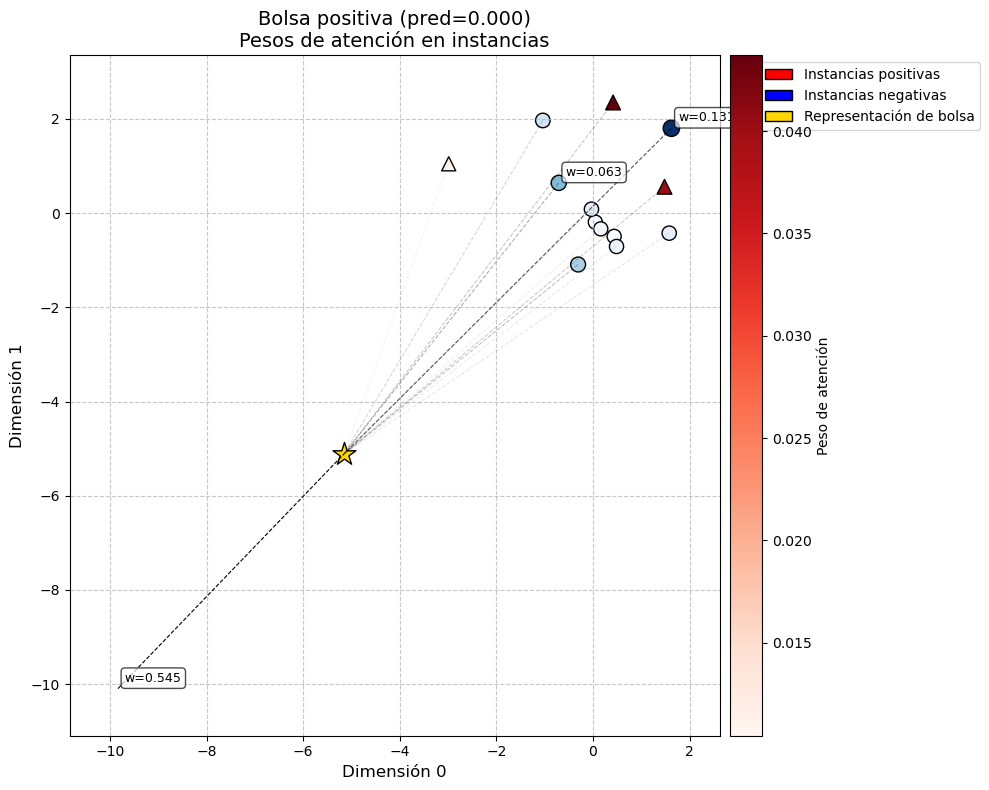

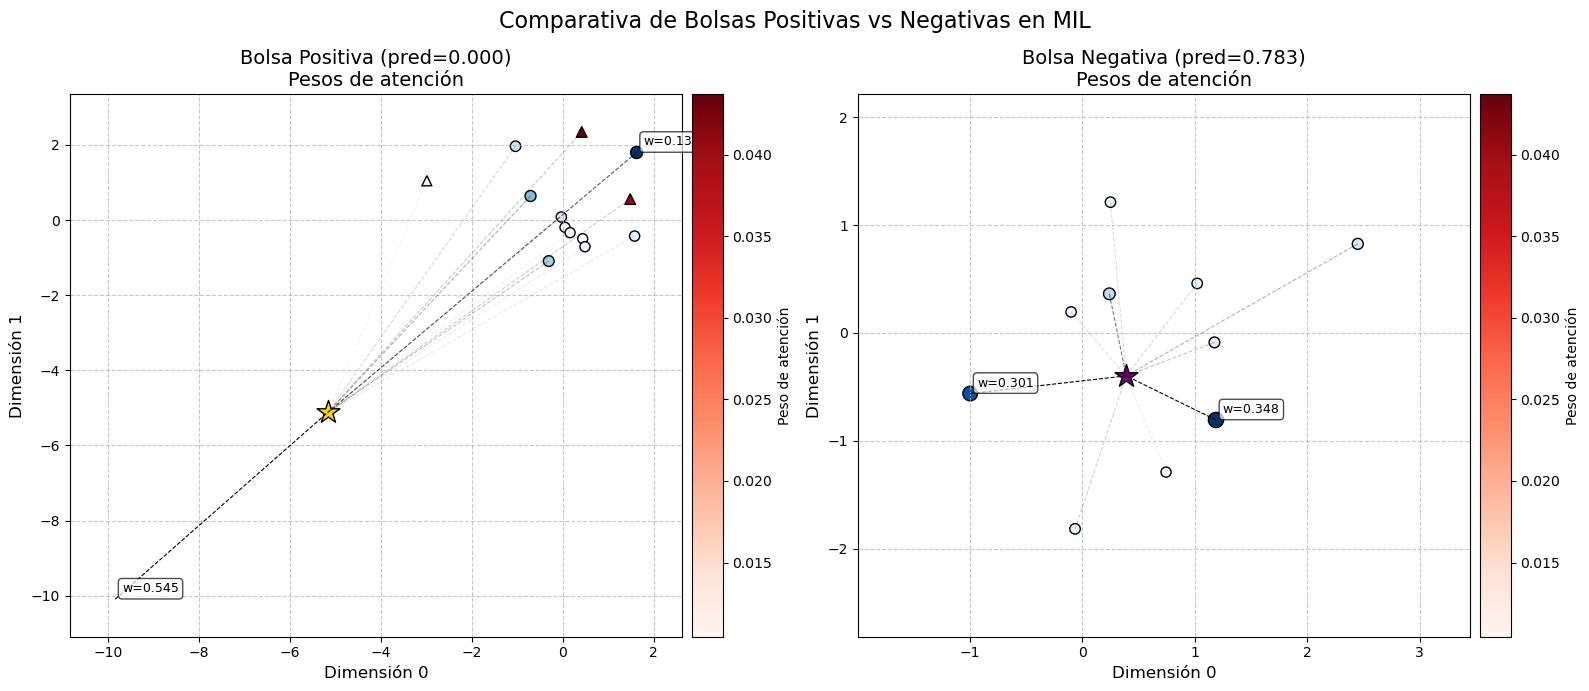

/tmp/ipykernel_1577911/383822097.py:383: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(lambdas))
/tmp/ipykernel_1577911/383822097.py:467: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


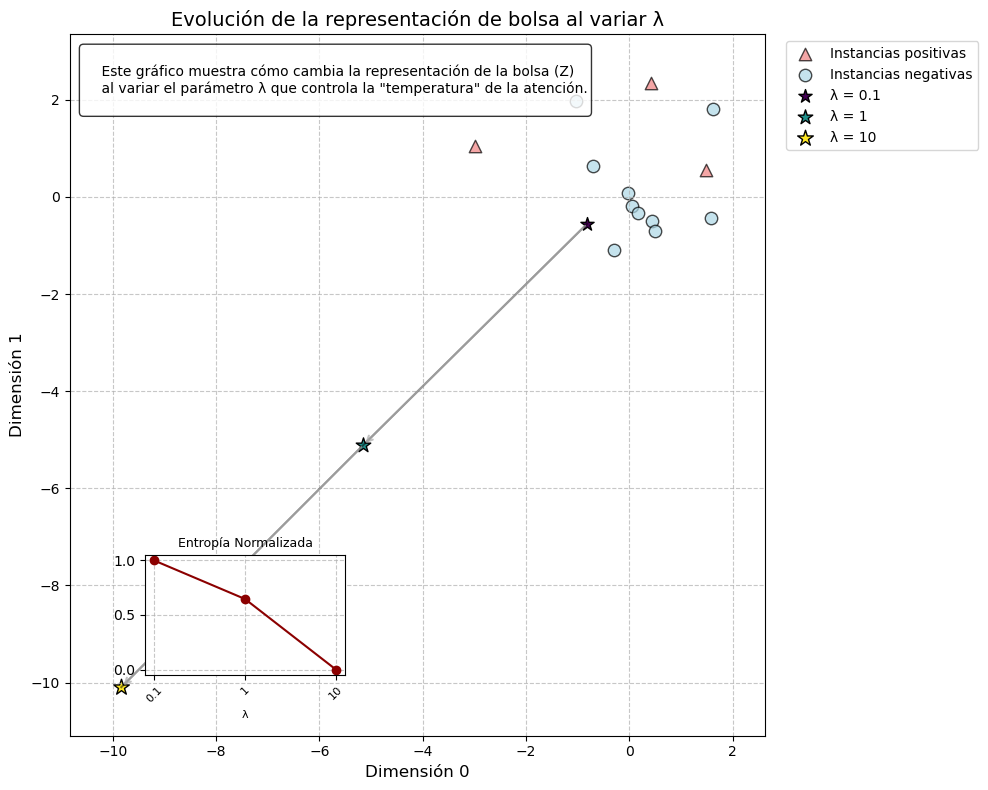

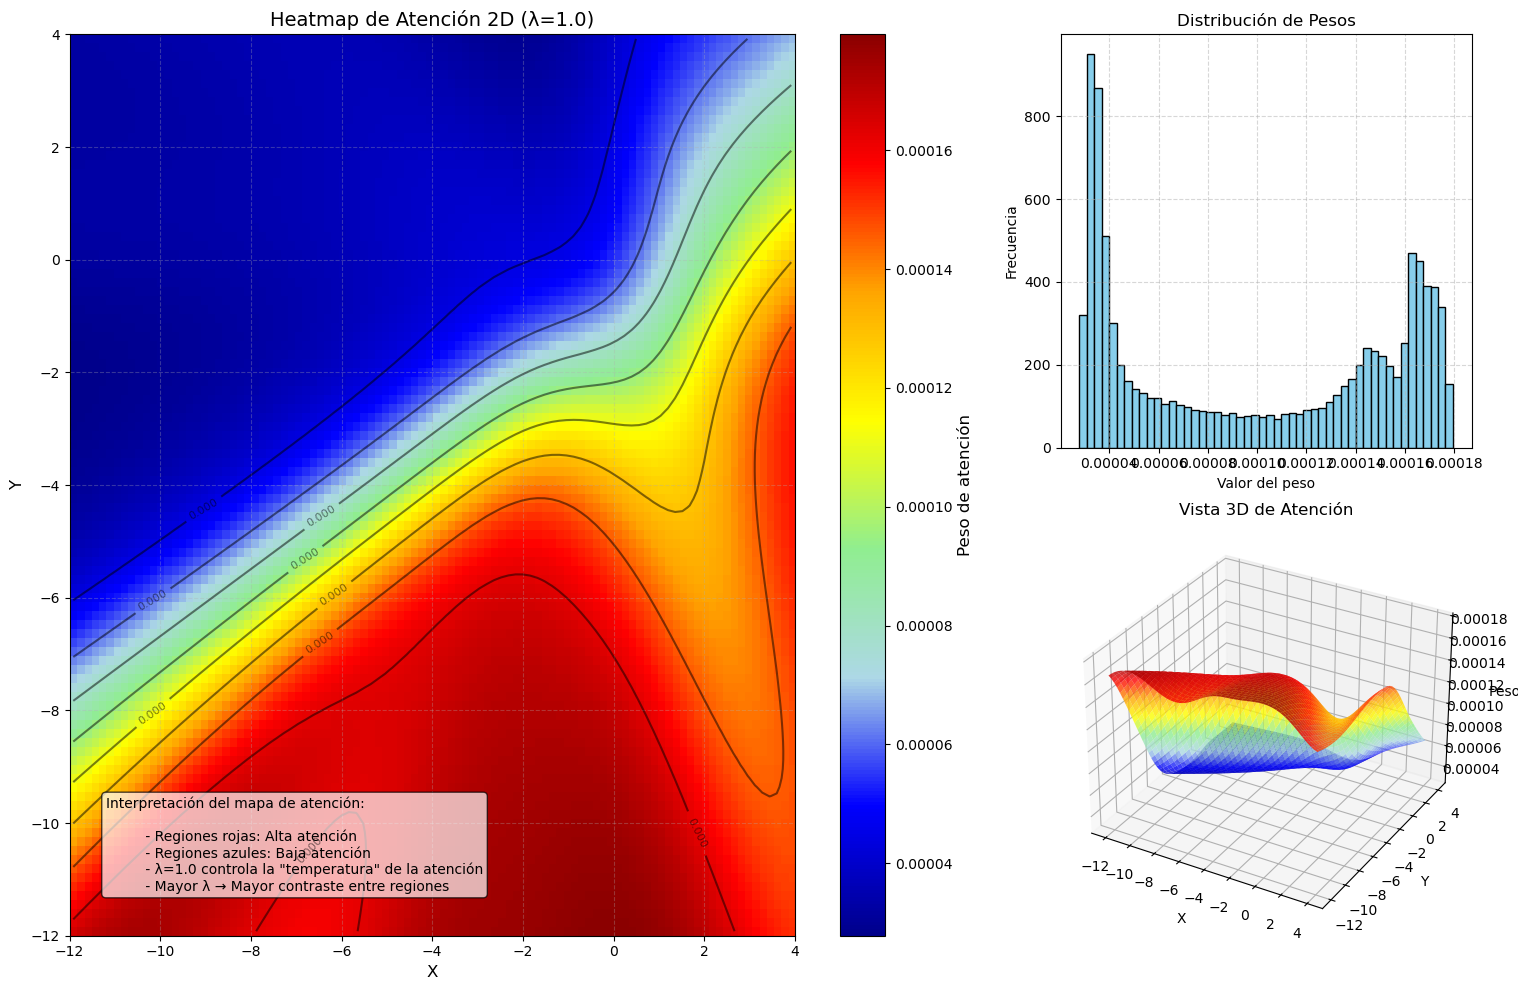

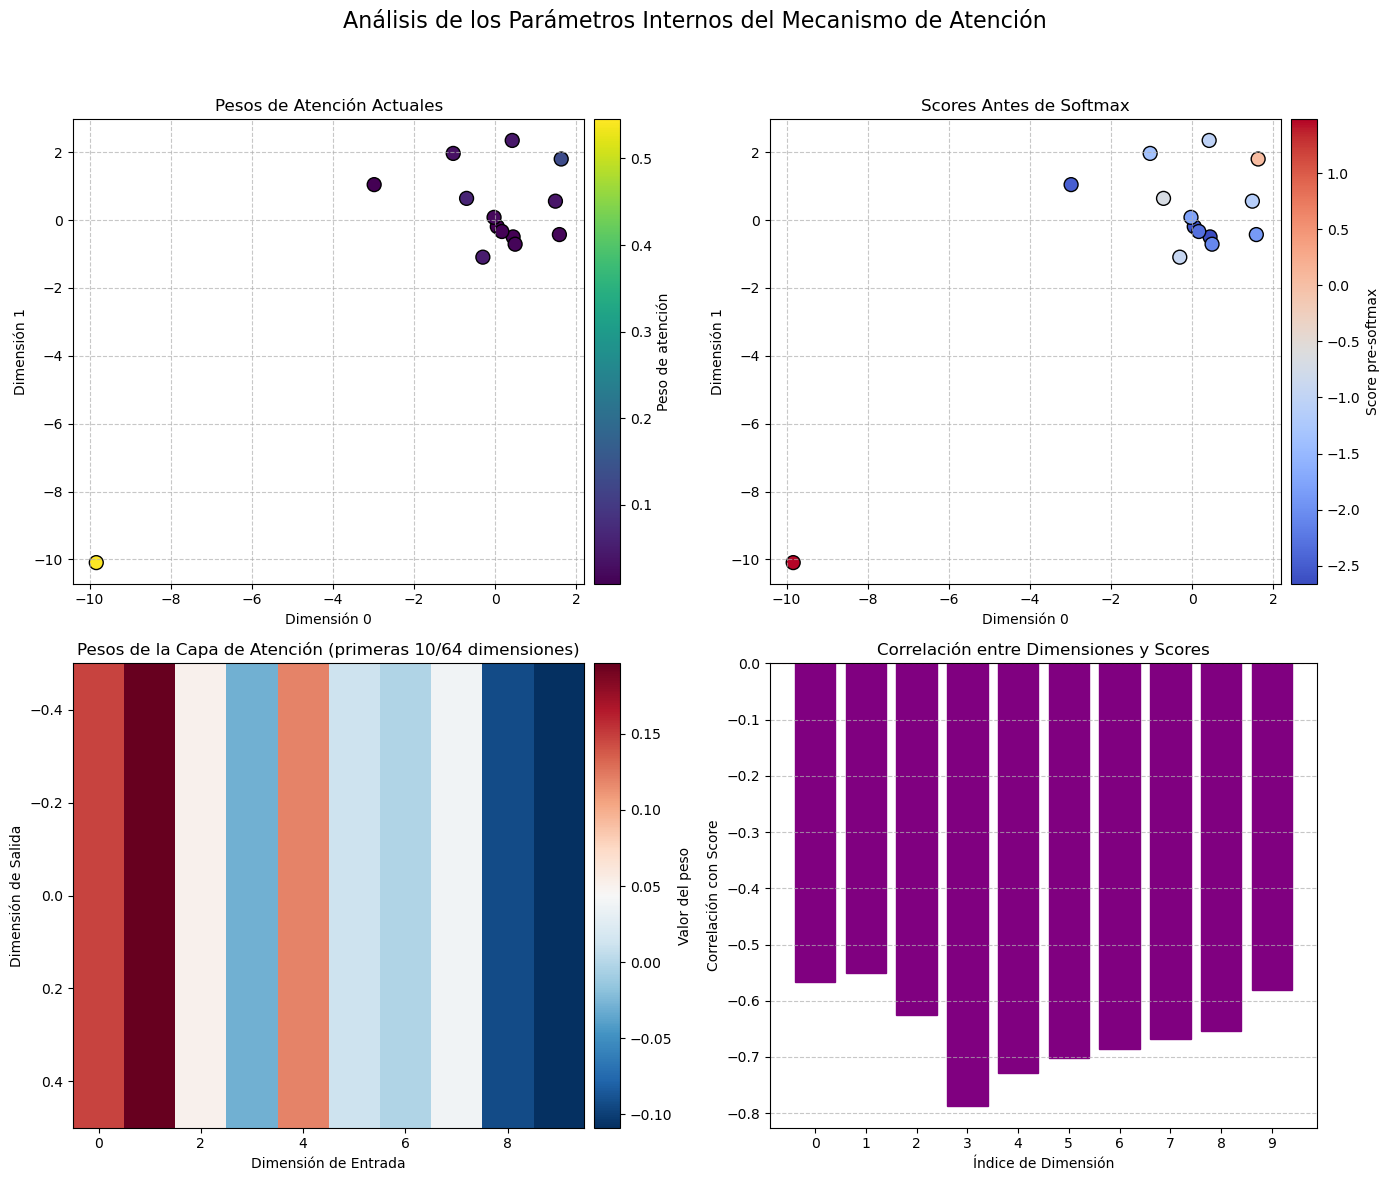

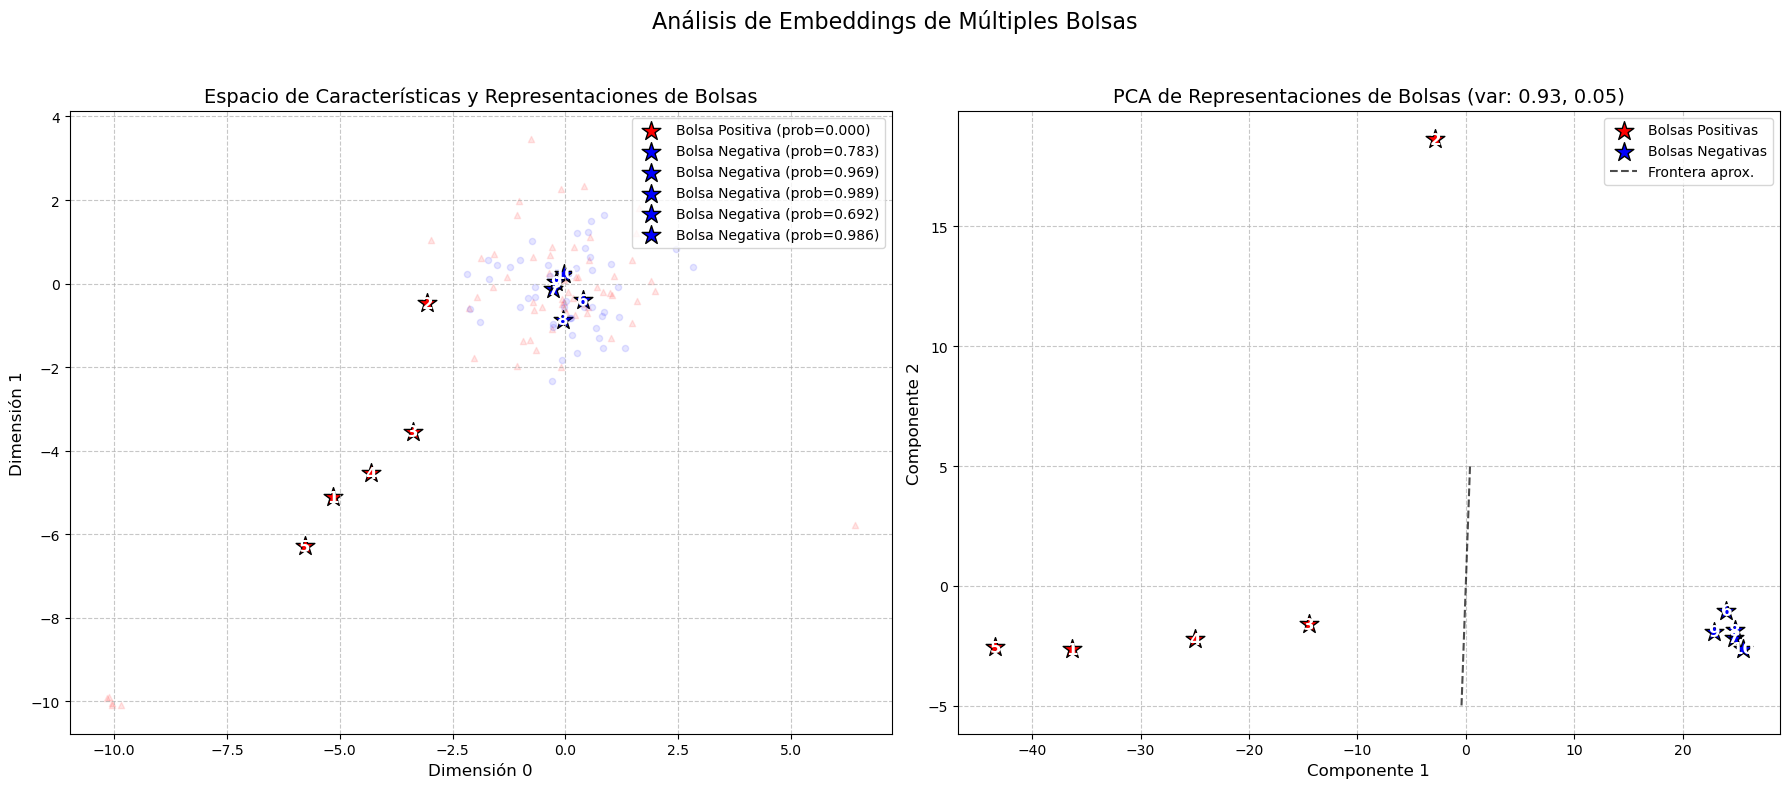

(<Figure size 1800x800 with 2 Axes>,
 (<Axes: title={'center': 'Espacio de Características y Representaciones de Bolsas'}, xlabel='Dimensión 0', ylabel='Dimensión 1'>,
  <Axes: title={'center': 'PCA de Representaciones de Bolsas (var: 0.93, 0.05)'}, xlabel='Componente 1', ylabel='Componente 2'>))

In [20]:
# -----------------------------------------------------------------------------
#   paint_ds: Usa las funciones definidas arriba
# -----------------------------------------------------------------------------

# 1) Crear loaders
train_loader, test_loader = make_dataloaders(SCStandardMILDataset,
                                            D=128, num_bags=1000, B=10)

# 2) Entrenar y guardar (opcional si ya tienes modelo)
model = train_mil_model(train_loader,
                        feature_dim=128,
                        pooling='attention',
                        lr=1e-3,
                        epochs=10,
                        save_path='models/scstandard/model_attn.pth')

# 3) Evaluar
evaluate_mil_model(model, test_loader)

# 4) OOD scores
compute_ood_scores(model, test_loader)

# 5) Visualizaciones
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LAMBDAS = [0.1, 1, 10]  # Valores de λ para la visualización
DIMS = (0, 1)
XRANGE = (-12, 4)
YRANGE = (-12, 4)

# Visualizaciones básicas mejoradas
plot_positive_bag_attention(test_loader, model, DEVICE, dims=DIMS)
plot_comparative_bags(test_loader, model, DEVICE, dims=DIMS)
plot_attention_trajectories(test_loader, model, DEVICE, lambdas=LAMBDAS, dims=DIMS)
plot_attention_heatmap_2d(grid_size=100,
                         x_range=XRANGE,
                         y_range=YRANGE,
                         hidden_dim=32,
                         lambda_val=1.0)

# Visualizaciones avanzadas adicionales
visualize_attention_parameters(model, test_loader, DEVICE, dims=DIMS)
plot_mil_bag_embedding(test_loader, model, DEVICE, n_bags=10, dims=DIMS)

MC STANDARD